## 1. Install Dependencies

In [ ]:
pip install --user --upgrade opencv-python numpy==1.23.0 matplotlib imutils scipy pandas cython

In [6]:
# import opencv
import cv2 as cv
# import math functions
import math
from math import dist
import numpy as np
# import system libraries
import glob
import os
# import distance calculation libraries
import imutils
from imutils import perspective
# import data processing libraries
import pandas
# import pytorch
import torch
# import socket
from ast import Break
import imp
from multiprocessing.connection import answer_challenge, wait
import socket
import time
# import machine learning model configs
from distutils.version import LooseVersion
import mmcv
from mmcv import Config
from mmdet.datasets import build_dataset
from mmrotate.datasets.builder import ROTATED_DATASETS
from mmrotate.datasets.mvtec import ScrewsDataset
from mmdet.apis import inference_detector, show_result_pyplot, set_random_seed

C:\Users\jense\AppData\Local\Temp\ipykernel_23728\3819040069.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\Users\jense\anaconda3\envs\mmyolo\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## 2. Define Functions

#### Function to find contours of an image:
*Takes a file path as input and returns contours*  

Contour resource: https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html  
Otsu Thresholding: https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

In [7]:
def find_contours_auto(image):
    # convert image to grayscale
    imgray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # threshold image with otsu thresholding
    blur = cv.GaussianBlur(imgray,(5,5),0)
    ret,thr = cv.threshold(blur, 120, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    
    # find contours
    # tree = all contours
    contours_tree, hierarchy = cv.findContours(thr, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # external = only extreme outer contours (used for orientation)
    contours_ext, hierarchy = cv.findContours(thr, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    contours_main = []
    for c in contours_tree:
        # Calculate the area of each contour
        area = cv.contourArea(c)

        # Ignore contours that are too small or too large
        if area > 5000 and 100000 > area:
            contours_main.append(c)
    """      
    result = image.copy()
    cv.drawContours(result, contours_main, -1, (0, 0, 255), 2)
    cv.imshow('Output Image', result)
    cv.waitKey(0)
    cv.destroyAllWindows()
    """
    return contours_main, contours_ext

In [8]:
def find_contours_man(image, min_t, max_t, min_a, max_a):
    # convert image to grayscale
    imgray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # manual threshold
    blur = cv.GaussianBlur(imgray,(5,5),0)
    ret,thr = cv.threshold(blur, min_t, max_t, cv.THRESH_BINARY)
    # find contours
    # tree = all contours
    contours_tree, hierarchy = cv.findContours(thr, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # external = only extreme outer contours (used for orientation)
    contours_ext, hierarchy = cv.findContours(thr, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    contours_t = []
    contours_e = []
    for t,e in zip(contours_tree, contours_ext):
        # Calculate the area of each contour
        areaT = cv.contourArea(t)
        areaE = cv.contourArea(e)

        # Ignore contours that are too small or too large
        if areaT > min_a and max_a > areaT:
            contours_t.append(t)
        if areaE > min_a and max_a > areaE:
            contours_e.append(e)

    return contours_t, contours_e

#### Finding centroid of object:
*Takes a list of contours and returns the centroid for each through moments*  

Code base from https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html

In [9]:
def find_centroids(contours):
    # instantiate two empty lists
    cX, cY = [], []
    for c in contours:
        # calculate moments for each contour
        M = cv.moments(c)
        # avoid divide by zero error
        if M["m00"] == 0:
            return 0, 0
        # calculate x,y coordinate of center
        cX.append(int(M["m10"] / M["m00"]))
        cY.append(int(M["m01"] / M["m00"]))
        """
        result = img.copy()
        cv.drawContours(result, contours, -1, (0, 0, 255), 2)
        cv.circle(img, (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])), 5, (0, 0, 0), -1)
        cv.imshow('Output Image', result)
        cv.waitKey(0)
        cv.destroyAllWindows()
        """
        
    return cX, cY

#### Calculate the orientation of an image through a rotated box:


Code based from: https://stackoverflow.com/questions/58632469/how-to-find-the-orientation-of-an-object-shape-python-opencv

In [10]:
def calculate_orientation(contours): 
    # instantiate an empty list
    angles = []
    for c in contours:
        # calculate bounding box with minimum area, considers rotation
        rect = cv.minAreaRect(c)
        box = cv.boxPoints(rect)
        
        # calculate rotation angle
        angle = rect[-1]
        if angle > 45:
            angle = 90 - angle
        else:
            angle = -angle
        angles.append(int(angle))
        """
        result = img.copy()
        box = np.int0(box)
        cv.drawContours(result,[box],0,(0,0,255),2)
        cv.imshow("RESULT", result)
        cv.waitKey(0)
        cv.destroyAllWindows()
        """
    return angles

#### Calculate dimension of objects using a bounding box:  
Code Reference: https://pyimagesearch.com/2016/03/28/measuring-size-of-objects-in-an-image-with-opencv/

In [11]:
def midpoint(ptA, ptB): # used for calculating distances
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

def calculate_dists(image, width, contours):
    # sort contours smallest to largest
    sorted_contours = sorted(contours, key=cv.contourArea, reverse=False)
    pixelsPerMetric = None
    
    for cnt in sorted_contours:
        result = image.copy()
        box = cv.minAreaRect(cnt)
        box = cv.boxPoints(box)
        box = np.array(box, dtype="int")
        box = perspective.order_points(box)
        
        # calculate dimensions of object
        (tl, tr, br, bl) = box # indicates corners of bounding box
        mtlr = midpoint(tl, tr)
        mblr = midpoint(bl, br)
        mtll = midpoint(tl, bl)
        mbrr = midpoint(tr, br)
        center = midpoint(mtlr,mblr)

        # compute the Euclidean distance between the midpoints
        dA = np.linalg.norm(np.array(mtlr)-np.array(mblr))
        dB = np.linalg.norm(np.array(mtll)-np.array(mbrr))

        # compute the size of the object using given metric
        if pixelsPerMetric is None:
            pixelsPerMetric = dB / width

        hght = dA / pixelsPerMetric
        wdth = dB / pixelsPerMetric

        cv.putText(image, "{:.2f}x{:.2f}in".format(hght, wdth), 
                    (int(center[0] - 35), int(center[1] - 10)), 
                    cv.FONT_HERSHEY_SIMPLEX, 0.35, (218, 198, 38), 1)
        """
        box = np.int0(box)
        cv.drawContours(result,[box],0,(0,0,255),2)
        cv.imshow("RESULT", result)
        cv.waitKey(0)
        cv.destroyAllWindows()
        """

#### Functions to draw contours, centroids, and orientation axes on an image:
*Takes an image, a contours list, orientation, and centroid coordinates and returns an image with the added features*  

In [12]:
def draw_contours(image, contours):
    # draw contours
    for c in contours:
        cv.drawContours(image, contours, -1, (0, 0, 255), 2)
        
def draw_orientation(image, angles, cX, cY):
    for i, (a, x, y) in enumerate(zip(angles, cX, cY)):
        # draw centroid
        cv.circle(image, (x, y), 3, (0, 0, 0), -1)
        # calculate orientation axes
        hypotenuse = 100
        x_axisX = int(x+hypotenuse*math.cos(math.radians(a)))
        x_axisY = int(y-hypotenuse*math.sin(math.radians(a)))
        y_axisX = int(x-hypotenuse*math.sin(math.radians(a)))
        y_axisY = int(y-hypotenuse*math.cos(math.radians(a)))
        # draw axes
        cv.line(image, (x, y), (x_axisX, x_axisY), (127,255,0), 2)
        cv.line(image, (x, y), (y_axisX, y_axisY), (255,255,224), 2)

def draw_all(image, contours, angles, cX, cY):
    result =  image.copy()
    draw_contours(result, contours)
    draw_orientation(result, angles, cX, cY)
    cv.imshow('Output Image', result)
    cv.waitKey(0)
    cv.destroyAllWindows()

def draw_features(image, contours, angles, cX, cY):
    # Make a copy of the image to draw on
    result =  image.copy()
    for i, (c, a, x, y) in enumerate(zip(contours, angles, cX, cY)):
        # draw contours
        cv.drawContours(result, contours, -1, (0, 0, 255), 2)
        # draw centroid
        cv.circle(result, (x, y), 3, (0, 0, 0), -1)
        # calculate orientation axes (use complex numbers functions to simplify)
        hypotenuse = 100
        x_axisX = int(x+hypotenuse*math.cos(math.radians(a)))
        x_axisY = int(y-hypotenuse*math.sin(math.radians(a)))
        y_axisX = int(x-hypotenuse*math.sin(math.radians(a)))
        y_axisY = int(y-hypotenuse*math.cos(math.radians(a)))
        cv.putText(result, "{:.1f}deg".format(a), 
                    (int(x - 35), int(y + 10)), 
                    cv.FONT_HERSHEY_SIMPLEX, 0.35, (218, 198, 38), 1)
        # draw axes
        cv.line(result, (x, y), (x_axisX, x_axisY), (127,255,0), 2)
        cv.line(result, (x, y), (y_axisX, y_axisY), (255,255,224), 2)
    cv.imshow('Output Image', result)
    cv.waitKey(0)
    cv.destroyAllWindows()

#### Miscallaneous Functions
*Nothing function is a dummy function for creating trackbars/number sliders*  
Trackbar code from: https://blog.electroica.com/trackbar-in-opencv-python/

In [13]:
def nothing(x): #dummy function for trackbar
    pass

In [14]:
def check_folder(folder_name): #makes new directory if it does not already exist
    path = os.path.join(os.getcwd(), folder_name)
    print(path)
    if not os.path.exists(path):
        os.makedirs(path)

In [15]:
def clear_images(folder_name, image_start): #removes all specified images from folder
    path = os.path.join(os.getcwd(), folder_name)
    for fname in os.listdir(path):
        if fname.startswith(image_start):
            os.remove(os.path.join(path,fname))

## Section 3. Calibrate Camera  
Webcam code reference: https://stackoverflow.com/questions/34588464/python-how-to-capture-image-from-webcam-on-click-using-opencv  
Calibration code reference: https://learnopencv.com/camera-calibration-using-opencv/  
Opencv Calibration doc: https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html

In [16]:
def take_webcam_pics(num, folder_name):
    check_folder(folder_name)
    #clear_images(folder_name, "calibration_pic")
    
    webcamVideo = cv.VideoCapture(0)
    cv.namedWindow("webcam") # used to display camera feed
    
    print("press space to save an image")
    while num >= 1:
        ret, frame = webcamVideo.read()
        if not ret: # check if camera is working
            print("Camera off")
            break
            
        cv.imshow("feed", frame) # display camera feed
         
        k = cv.waitKey(1) & 0xFF #gets value of key pressed
        if k == 27: # esc key pressed
            print("Escape hit, closing...")
            break
        elif k == 32: # space key pressed
            image_path = os.path.join(os.getcwd(), folder_name, "calibration_pic_{}.jpg".format(num))
            cv.imwrite(image_path, frame)            
            print("saving image")
            num -= 1
    webcamVideo.release()
    cv.destroyAllWindows()      
        

In [17]:
def cam_cal(newpics = False): # determine if new cals are needed
    # Defining the dimensions of checkerboard
    CHECKERBOARD = (7,10) # checkerboard needs to be large enough to load
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    # Creating vector to store vectors of 3D points for each checkerboard image
    objpoints = [] 
    # Creating vector to store vectors of 2D points for each checkerboard image
    imgpoints = [] 

    # Defining the world coordinates for 3D points
    objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
    prev_img_shape = None

    # Extracting path of individual image stored in a given directory
    if(newpics): #
        take_webcam_pics(20, "calibs") #Take 20 pictures for calibration
    images = glob.glob('./calibs/*.jpg')
    for fname in images:
        img = cv.imread(fname)
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        # Find the chess board corners
        # If desired number of corners are found in the image then ret = true
        ret, corners = cv.findChessboardCorners(gray, CHECKERBOARD, 
            cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)
        """
        If desired number of corner are detected,
        we refine the pixel coordinates and display them on the images of checker board
        """
        if ret == True:
            objpoints.append(objp)
            # refining pixel coordinates for given 2d points.
            corners2 = cv.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
            imgpoints.append(corners2)

            # Draw and display the corners
            #img = cv.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)

        #cv.imshow('img',img) # show images
        #cv.waitKey(0)

    cv.destroyAllWindows()

    h,w = img.shape[:2]

    """
    Performing camera calibration by passing the value of known 3D points (objpoints)
    and corresponding pixel coordinates of the detected corners (imgpoints)
    """
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # print calibration values
    """
    print("Camera matrix : \n")
    print(mtx)
    print("dist : \n")
    print(dist)
    print("rvecs : \n")
    print(rvecs)
    print("tvecs : \n")
    print(tvecs)
    """
    return ret, mtx, dist, rvecs, tvecs # return calibration values for future images

In [18]:
def undistort_img(img, mtx, dist):
    #img = cv.imread(img)
    h, w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    
    # undistort
    dst = cv.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    #cv.imwrite('calibresult.png', dst)
    return dst

## Section 4. Coordinate System Definition

Define Coordinate System from the *top right corner* of the *leftmost object*

In [19]:
def find_bottom_contour(contours):
    sorted_contours = sorted(contours, key=lambda contours: cv.boundingRect(contours)[1], reverse=False) # sort left-to-right
    leftmost = []
    remainder = []
    for ind, cnt in enumerate(sorted_contours):
        if ind == 0:
            leftmost = cnt
        else:
            remainder.append(cnt)
    return leftmost, remainder
    
def draw_axes(imagedraw, origin, mtx, dist):
    CHECKERBOARD = (7,10)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    objp = np.zeros((CHECKERBOARD[0]*CHECKERBOARD[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:CHECKERBOARD[0],0:CHECKERBOARD[1]].T.reshape(-1,2)
    axis = np.float32([[10,0,0], [0,10,0], [0,0,-10]]).reshape(-1,3)
    
    img = cv.imread("./calibs/calibration_pic_1.jpg")
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    ret, corners = cv.findChessboardCorners(gray, CHECKERBOARD, None)
    if ret == True:
        corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Find the rotation and translation vectors.
        ret, rvecs, tvecs = cv.solvePnP(objp, corners2, mtx, dist)
        # project 3D points to image plane
        imgpts, jac = cv.projectPoints(axis, rvecs, tvecs, mtx, dist)
        #print(origin)
        #print(imgpts[0].ravel(), imgpts[1].ravel(), imgpts[2].ravel())
        # draw x,y,z axes from origin (leftmost centroid contour)
        imagedraw = cv.line(imagedraw, origin, (int(imgpts[0].ravel()[0]), int(imgpts[0].ravel()[1])), (255,0,0), 5)
        imagedraw = cv.line(imagedraw, origin, (int(imgpts[1].ravel()[0]), int(imgpts[1].ravel()[1])), (0,255,0), 5)
        imagedraw = cv.line(imagedraw, origin, (int(imgpts[2].ravel()[0]), int(imgpts[2].ravel()[1])), (0,0,255), 5)

    return imagedraw

## 5. Import/Load Pytorch Model

In [20]:
model = torch.load("screw.pt")
cfg = Config.fromfile('./mmrotate/configs/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90.py')

cfg.data['workers_per_gpu']=0

# Modify dataset type and path
cfg.dataset_type = 'ScrewsDataset'
cfg.data_root = 'demo/screwdata/'

cfg.data.test.type = 'ScrewsDataset'
cfg.data.test.data_root = 'demo/screwdata/'
cfg.data.test.ann_file = 'val'
cfg.data.test.img_prefix = 'images'

cfg.data.train.type = 'ScrewsDataset'
cfg.data.train.data_root = 'demo/screwdata/'
cfg.data.train.ann_file = 'train'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'ScrewsDataset'
cfg.data.val.data_root = 'demo/screwdata/'
cfg.data.val.ann_file = 'val'
cfg.data.val.img_prefix = 'images'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 13
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'

model.cfg = cfg

# Add an attribute for visualization convenience
datasets = [build_dataset(cfg.data.train)]
model.CLASSES = datasets[0].CLASSES

print(model.CLASSES) # check for screws dataset classes

model.eval()

('long_lag_screw', 'lag_wood_screw', 'wood_screw', 'short_wood_screw', 'shiny_screw', 'black_oxide_screw', 'nut', 'bolt', 'large_nut', 'nut', 'nut', 'machine_screw', 'short_machine_screw')


OrientedRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

extracting bounding box details: https://vinleonardo.com/detecting-objects-in-pictures-and-extracting-their-data-using-mmdetection/

In [21]:
# Individual Image Testing
#img = mmcv.imread('mmrotate/demo/screwdata/images/screws_210.png')
#model.cfg = cfg
#result = inference_detector(model, img)
#show_result_pyplot(model, img, result, score_thr=0.3)

def parse_bbox(result):
    bbox_result = result
    # if instance segmentation
    # bbox_result, segm_result = result
    labels = [np.full(bbox.shape[0], i, dtype=np.int32) for i, bbox in enumerate(bbox_result)]
    labels = np.concatenate(labels)
    bboxes = np.vstack(bbox_result)
    labels_impt = np.where(bboxes[:, -1] > 0.3)[0]

    classes = model.CLASSES
    labels_impt_list = [labels[i] for i in labels_impt]
    labels_class = [classes[i] for i in labels_impt_list]

    index = 0;
    threshold = -1;
    for i, bbox in enumerate(bboxes[labels_impt]):
        print(i, bbox)
        if bbox[i] > threshold:
            threshold = bbox[i]
            index = i
    if threshold == -1:
        return "null", 0, 0, 0, 0, 0, -1
    lbl = labels_class[i]
    cx = bboxes[labels_impt][i][0]
    cy = bboxes[labels_impt][i][1]
    width = bboxes[labels_impt][i][2]
    height = bboxes[labels_impt][i][3]
    rotation = bboxes[labels_impt][i][4]
    rotation = math.degrees(rotation)
    threshold = bboxes[labels_impt][i][5]
    print(lbl, cx, cy, rotation, threshold)
    return lbl, cx, cy, width, height, rotation, threshold

#print(lbl, cx, cy, width, height, rotation, threshold)
#print(bboxes)

# Extra testing 

#from matplotlib import image
#from matplotlib import pyplot as plt
  
# to read the image stored in the working directory
#data = image.imread('mmrotate/demo/screwdata/images/screws_210.png')
  
#lbl, cx, cy, width, height, rotation, threshold = parse_bbox(result)
#plt.plot(cx, cy, marker='o', color="red")
#plt.plot([cx-width/2, cx+width/2], [cy, cy], color="white", linewidth=2)
#plt.plot([cx, cx], [cy-height/2, cy+height/2], color="white", linewidth=2)
#plt.imshow(data)
#plt.show()


## Section 6. Socket Definition

Socket information https://realpython.com/python-sockets/

In [22]:
IP = socket.gethostbyname(socket.gethostname())
IP_2 = "127.0.0.1" # Yumi IP address/ 192.168.125.1 (localhost)
print(IP)
# print(IP_2)

PORT = 4455
ADDR = (IP,PORT)
Format = "utf-8"
Size = 1024

192.168.0.170


## Section 6. Main  Function

Active Calibrated Video Capture with Contouring and Orientation Display

[Starting] Server is starting.
[Listening] Server is listening.
[NEW CONNECTION] ('192.168.0.170', 61058) connected.
Client Message has been received:  Ready


C:\Users\jense\anaconda3\envs\mmyolo\lib\site-packages\mmdet\models\dense_heads\anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


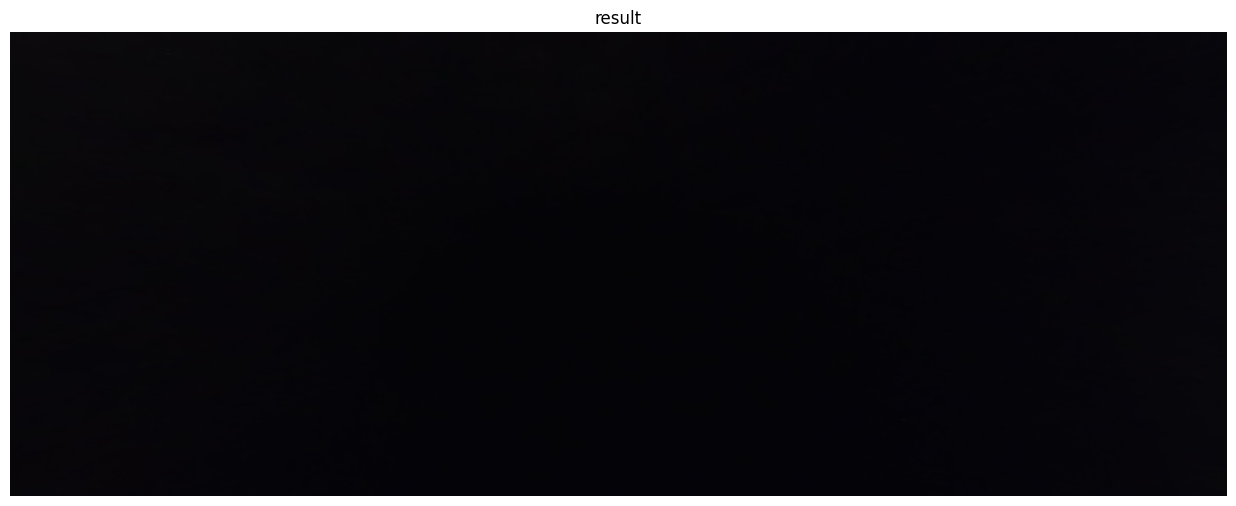

['0', '0', '0', 'null', 'Done']
Client Message 2 has been received:  StopStop
[Listening] Server is listening.
[NEW CONNECTION] ('192.168.0.170', 61063) connected.
Client Message has been received:  Ready


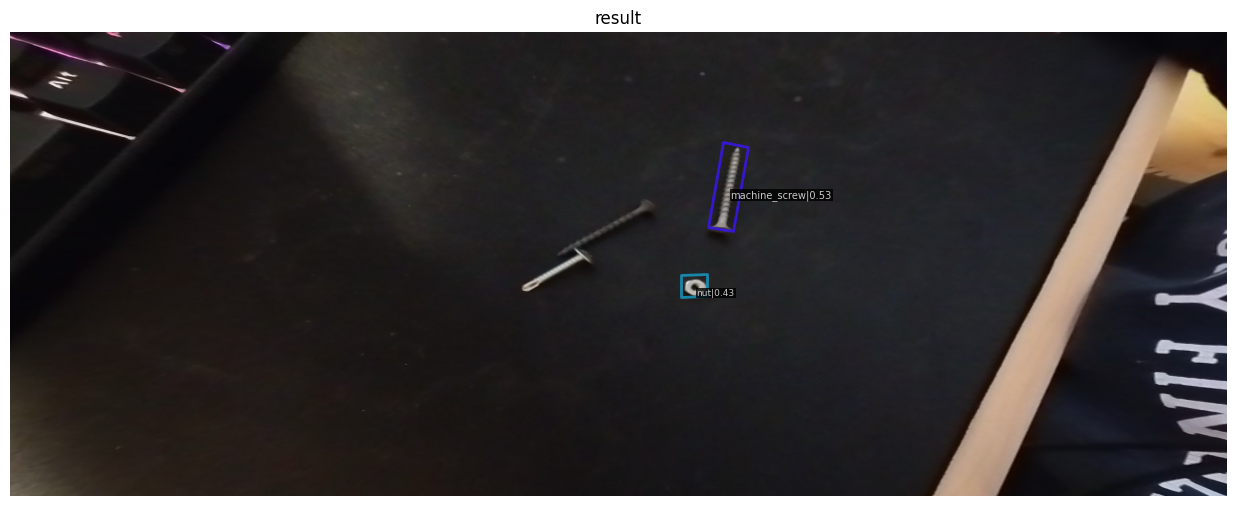

0 [ 6.8439e+02  2.5407e+02  2.5838e+01  2.1962e+01 -1.7313e-02  4.2588e-01]
1 [ 7.1848e+02  1.5524e+02  8.5565e+01  2.6144e+01 -1.3931e+00  5.2631e-01]
machine_screw 718.4776 155.23836 -79.81840343328024 0.526305
['718.4776', '155.23836', '-79.81840343328024', 'machine_screw', 'Done']
Client Message 2 has been received:  Ready
[Listening] Server is listening.


In [ ]:
cal_needed = False
if(os.listdir(".\calibs") == []):
    cal_needed = True
#print(os.listdir(".\calibs"))
ret, mtx, dist, rvecs, tvecs = cam_cal(cal_needed) # calibrate camera

# Start active video capture
webcamVideo = cv.VideoCapture(0)
#cv.namedWindow("webcam") # used to display camera feed

# Socket Info
client_message = "" # Reset client message
print(f"\033[33m[Starting]\033[0m Server is starting.")
server = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
server.bind(ADDR)
server.listen()

# Main Function 
while client_message != "Stop":
    server_message = [] # Reset server message
    
    # Webcam start
    ret, frame = webcamVideo.read()
    undist_frame = undistort_img(frame, mtx, dist) # apply camera calibration
    imgcopy = undist_frame.copy() # copy undistorted image for any processing
    
    if ret: # if webcam video works
        cv.imshow("frame", frame) #show distorted frame
    else:
        print('no video')
        webcamVideo.set(cv.CAP_PROP_POS_FRAMES, 0)
        continue
    
    # Client connected  
    print(f"\033[33m[Listening]\033[0m Server is listening.")
    conn, addr = server.accept() 
    with conn: # with a connection
        print(f"\033[33m[NEW CONNECTION]\033[0m {addr} connected.")
        client_message = conn.recv(Size).decode(Format) # read message to string
        print("Client Message has been received: ", client_message)
        if client_message == "Next":
            continue
        if client_message == "Stop":
            break
        if client_message == "Ready" :
            result = inference_detector(model, imgcopy) #Run image detection
            #print(result)
            show_result_pyplot(model, imgcopy, result, score_thr=0.3)
            lbl, cx, cy, width, height, theta, threshold = parse_bbox(result)
            server_message = [str(cx), str(cy), str(theta), lbl, "Done"]
            print(server_message)
            for i in range(len(server_message)):
                temp_str = server_message[i]
                conn.sendto(str.encode(temp_str,Format),addr)
                time.sleep(.25)
            client_message = ""
            time.sleep(.25)
        #client_message = conn.recv(Size).decode(Format) # read message to string
        #print("Client Message 2 has been received: ", client_message)
    conn.close()
    #result = inference_detector(model, imgcopy) #Run image detection
    #lbl, cx, cy, width, height, theta, threshold = parse_bbox(result)
    #server_message = [str(cx), str(cy), str(theta), lbl, "Done"]
    #print(server_message)
    cv.imshow("undist_feed", imgcopy) # display undistorted camera feed 
    
    k = cv.waitKey(1) & 0xFF #gets value of key pressed
    if k == 27: # esc key pressed
        print("Escape hit, closing...")
        break

webcamVideo.release()
cv.destroyAllWindows()      

In [18]:
display_type = 0 # image: 0 | webcam: 1 | video: 2

ret, mtx, dist, rvecs, tvecs = cam_cal(False) # calibrate camera
print("Clearing active_pics")
clear_images(os.getcwd(), "active_pic") # clear old active pics
image_num = 1

# create a seperate window named 'controls' for trackbar
cv.namedWindow('controls', cv.WINDOW_NORMAL)
# create trackbars in 'controls' window
cv.createTrackbar('Min Thresh','controls',0,255,nothing)
cv.createTrackbar('Max Thresh','controls',255,255,nothing)
cv.createTrackbar('Min Area','controls',2000,10000,nothing)
cv.createTrackbar('Max Area','controls',1000000,200000,nothing)

# Start active video capture
#webcamVideo = cv.VideoCapture('Presentation1.mp4')
#cv.namedWindow("webcam") # used to display camera feed

print("press space to save an image")
while True:
    if display_type == 2: # video active capture
        ret, frame = webcamVideo.read()
        imgcopy = frame.copy()
        if ret:
            cv.imshow("frame", frame)
        else:
            print('no video')
            webcamVideo.set(cv.CAP_PROP_POS_FRAMES, 0)
            continue
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    if display_type == 1: # webcam active capture
        ret, frame = webcamVideo.read()
        undist_frame = undistort_img(frame, mtx, dist) # apply camera calibration
        imgcopy = undist_frame.copy()
        if not ret: # check if camera is working
            print("Camera off")
            break
    if display_type == 0: # static image capture
        #print(os.getcwd())
        #img = cv.imread("screws_198.png")
        img = cv.imread("input_img.jpg") #image2.png
        #print('Original Dimensions : ',img.shape)
        #img = cv.resize(img, (int(img.shape[1]*0.3), int(img.shape[0]*0.3)), cv.INTER_AREA)
        #cntrs_t, cntrs_e = find_contours_auto(img) # auto-generated contours values --> will be changed
        imgcopy = img.copy()
    
        
    # get Trackbar values
    min_thres = int(cv.getTrackbarPos('Min Thresh','controls'))
    max_thres = int(cv.getTrackbarPos('Max Thresh','controls'))
    area_min = int(cv.getTrackbarPos('Min Area','controls'))
    area_max = int(cv.getTrackbarPos('Max Area','controls'))
    
    # calculate contours
    #cntrs_t, cntrs_e = find_contours_auto(imgcopy)
    cntrs_t, cntrs_e = find_contours_man(imgcopy, min_thres, max_thres, area_min, area_max)
    leftmost, cntrs_t = find_bottom_contour(cntrs_t) # pops left most contour from list for axes
    _, cntrs_e = find_bottom_contour(cntrs_e) # shorten cntrs_e as well
    draw_contours(imgcopy, cntrs_t)
        
    #cv.imshow("orig_feed", frame) # display camera feed
    #imgcopy = draw_axes(imgcopy, tuple(find_centroids(leftmost)), mtx, dist) # draw axes using leftmost contour and calibration plane
    cv.imshow("undist_feed", imgcopy) # display undistorted camera feed
    
    k = cv.waitKey(1) & 0xFF #gets value of key pressed
    if k == 27: # esc key pressed
        print("Escape hit, closing...")
        break
    elif k == 32: # space key pressed
        image_path = os.path.join(os.getcwd(), "active_pic_{}.jpg".format(image_num))
        cv.imwrite(image_path, imgcopy)
        print("saving image: active_pic_{}.jpg".format(image_num))
        image_num += 1
        
#cap.release()
#webcamVideo.release()
cv.destroyAllWindows()      

# calculate and draw orientation/dimensions
x_coords, y_coords = find_centroids(cntrs_t)
angs = calculate_orientation(cntrs_e)
calculate_dists(imgcopy, 1, cntrs_e)
draw_features(imgcopy, cntrs_t, angs, x_coords, y_coords)

Clearing active_pics
press space to save an image
Escape hit, closing...


[>>                                                ] 20/372, 3.1 task/s, elapsed: 6s, ETA:   112s

KeyboardInterrupt: 

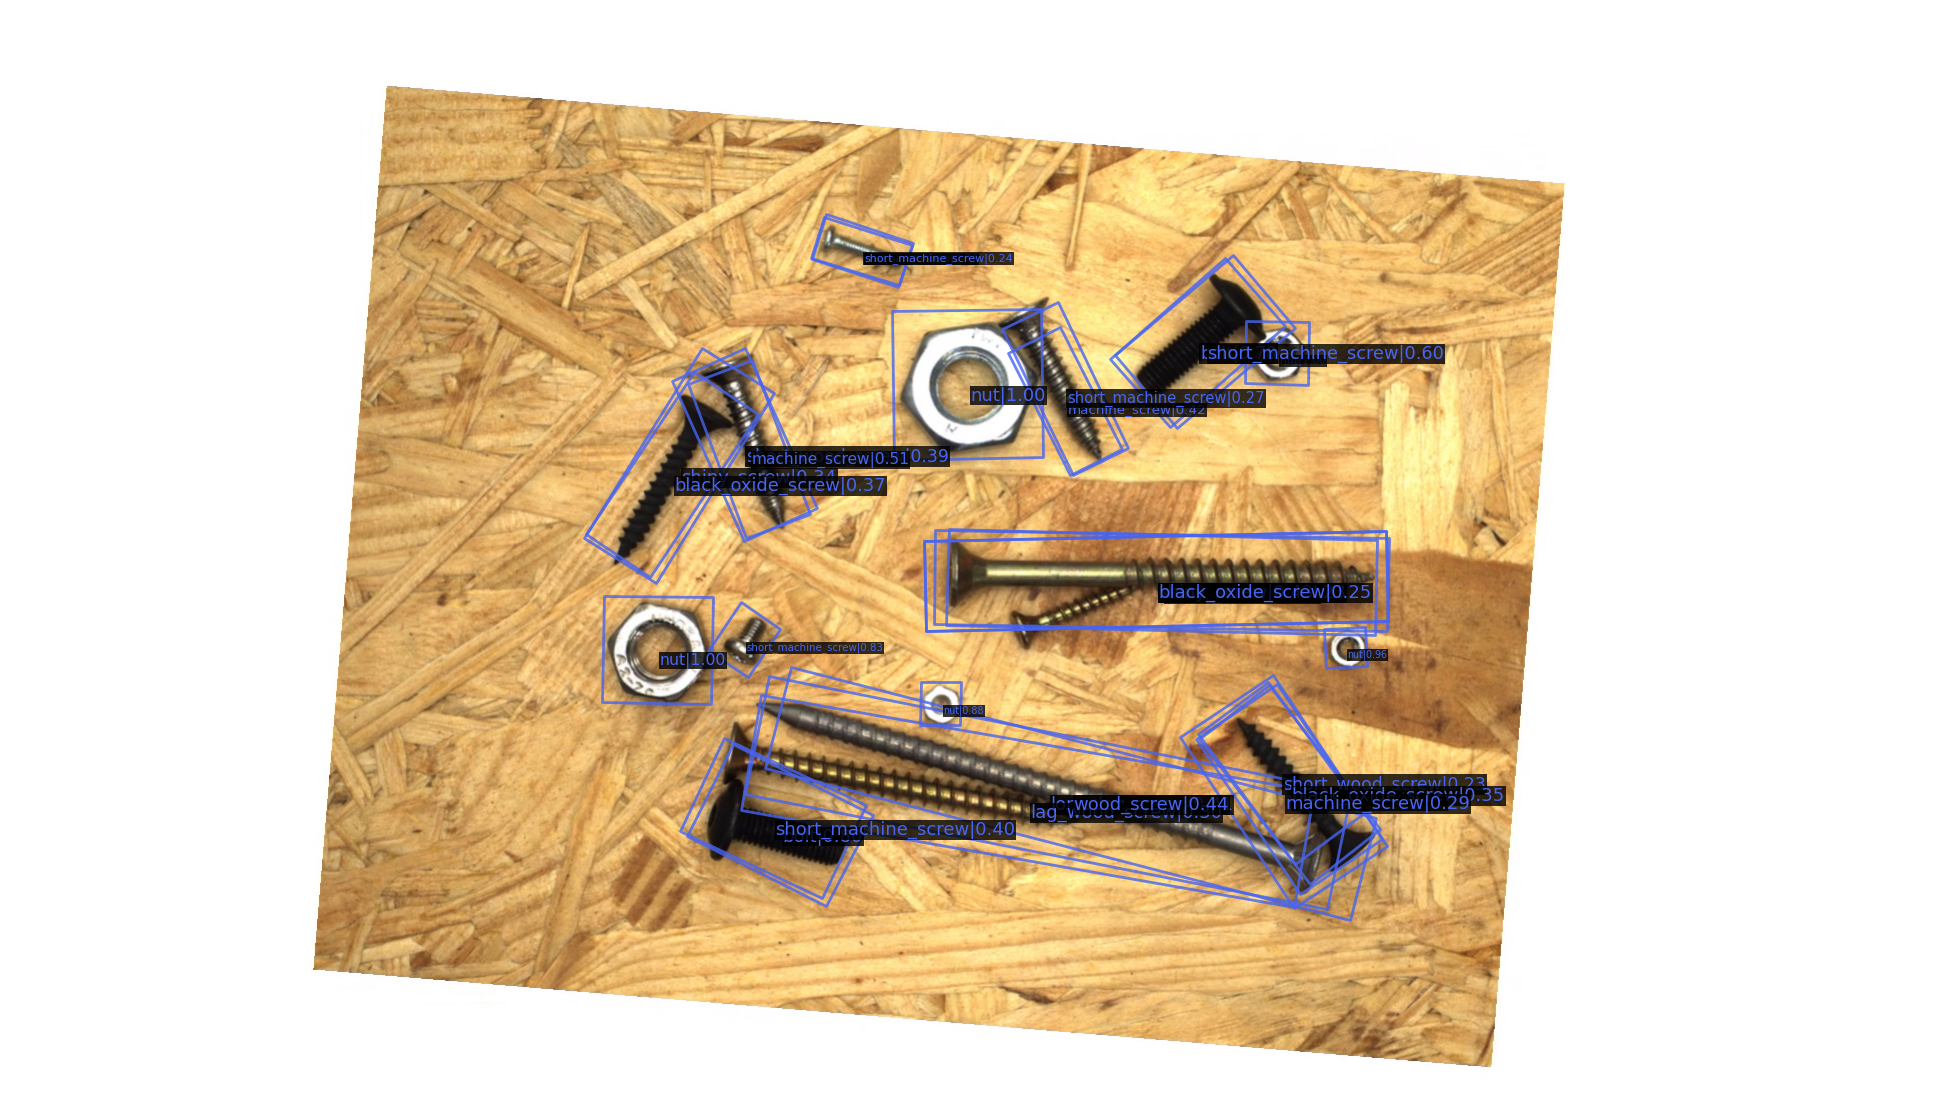

In [6]:
from mmdet.apis import inference_detector
#import argparse
import mmcv
import cv2
import time

# Build the model.
model = torch.load("screw.pt")
cap = mmcv.VideoReader('Presentation1.mp4') #Screws_and_Bolts.mp4
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("testyt.avi", fourcc, cap.fps, (cap.width, cap.height))
frame_count = 0 # To count total frames.
total_fps = 0 # To get the final frames per second.

for frame in mmcv.track_iter_progress(cap):
    # Increment frame count.
    frame_count += 1
    start_time = time.time()# Forward pass start time.
    result = inference_detector(model, frame)
    #print(result)
    end_time = time.time() # Forward pass end time.
    # Get the fps.
    fps = 1 / (end_time - start_time)
    # Add fps to total fps.
    total_fps += fps
    show_result = model.show_result(frame, result, score_thr=0.2)
    # Write the FPS on the current frame.
    cv2.putText(
        show_result, f"{fps:.3f} FPS", (15, 30), cv2.FONT_HERSHEY_SIMPLEX,
        1, (0, 0, 255), 2, cv2.LINE_AA
    )
    mmcv.imshow(show_result, 'Result', wait_time=1)
    out.write(show_result)
# Release VideoCapture()
out.release()
# Close all frames and video windows
cv2.destroyAllWindows()
# Calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

In [23]:
# defining a helper class for implementing multi-threading 
class WebcamStream :
    # initialization method 
    def __init__(self, stream_id=0):
        self.stream_id = stream_id # default is 0 for main camera 
        
        # opening video capture stream 
        self.video = cv.VideoCapture(self.stream_id)
        if self.video.isOpened() is False :
            print("[Exiting]: Error accessing webcam stream.")
            exit(0)
        fps_input_stream = int(self.video.get(5)) # hardware fps
        print("FPS of input stream: {}".format(fps_input_stream))
            
        # reading a single frame from video stream for initializing 
        self.grabbed , self.frame = self.video.read()
        if self.grabbed is False :
            print('[Exiting] No more frames to read')
            exit(0)
        # self.stopped is initialized to False 
        self.stopped = True
        # thread instantiation  
        self.t = Thread(target=self.update, args=())
        self.t.daemon = True # daemon threads run in background 
        
    # method to start thread 
    def start(self):
        self.stopped = False
        self.t.start()
    # method passed to thread to read next available frame  
    def update(self):
        while True :
            if self.stopped is True :
                break
            self.grabbed , self.frame = self.video.read()
            if self.grabbed is False :
                print('[Exiting] No more frames to read')
                self.stopped = True
                break 
        self.video.release()
    # method to return latest read frame 
    def read(self):
        return self.frame
    # method to stop reading frames 
    def stop(self):
        self.stopped = True

In [ ]:
from threading import Thread # library for multi-threading
from multiprocessing import Process, Pipe
import time
import os  
    
def camera_frames(pipe, frame):
    undist_frame = undistort_img(frame, mtx, dist) # apply camera calibration
    imgcopy = undist_frame.copy() # copy undistorted image for any processing
    cv.imshow("dist_feed", frame) # display undistorted camera feed
    cv.imshow("undist_feed", imgcopy) # display undistorted camera feed
    pipe.send(imgcopy)
    
def socket_connection(pipe, connection):
    imgcopy = pipe.recv()
    
    with connection: # with a connection
        print(f"\033[33m[NEW CONNECTION]\033[0m {addr} connected.")
        client_message = connection.recv(Size).decode(Format) # read message to string
        print("Client Message has been received: ", client_message)
        if client_message == "Next":
            print("Next")
        elif client_message == "Stop":
            print("Stop")
        else: #if client_message == "Ready" :
            result = inference_detector(model, imgcopy) #Run image detection
            #print(result)
            show_result_pyplot(model, imgcopy, result, score_thr=0.3)
            lbl, cx, cy, width, height, theta, threshold = parse_bbox(result)
            server_message = [str(cx), str(cy), str(theta), lbl, "Done"]
            print(server_message)
            for i in range(len(server_message)):
                temp_str = server_message[i]
                connection.sendto(str.encode(temp_str,Format),addr)
                time.sleep(.25)
            client_message = ""
            time.sleep(.25)
    connection.close()

    
cal_needed = False
if(os.listdir(".\calibs") == []):
    cal_needed = True
ret, mtx, dist, rvecs, tvecs = cam_cal(cal_needed) # calibrate camera
# Start active video capture
webcam_stream = WebcamStream(stream_id=0) # 0 id for main camera
webcam_stream.start()

# Socket Info
client_message = "" # Reset client message
print(f"\033[33m[Starting]\033[0m Server is starting.")
server = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
server.bind(ADDR)
server.listen()
while client_message != "Stop":
    print(f"\033[33m[Listening]\033[0m Server is listening.")
    conn, addr = server.accept() 

    frame = webcam_stream.read()
    
    parent_conn, child_conn = Pipe() 
  
    # creating new processes 
    p1 = Process(target=camera_frames, args=(parent_conn, frame))
    p2 = Process(target=socket_connection, args=(child_conn, conn)) 
  
    # running process p1 and p2
    p1.start()
    p2.start() 
webcam_stream.stop() # stop the webcam stream

webcamVideo.release()
cv.destroyAllWindows()      

[Starting] Server is starting.
[Listening] Server is listening.
FPS of input stream: 30
